# NGC 4380 Analysis

Isaac Cheng - October 2021

This is meant to be a compilation/walkthrough of how to generate many of the different
plots and data products related to the analysis of a galaxy using NGVS and VERTICO data.
Additionally, this notebook can act as a template for the analysis of other galaxies.

Note that these cells should be run sequentially, as subsequent cells may rely on data
from previous cells. I have tried my best to keep each section as self-contained as
possible, but there are some cells which would be impractical to run every time.

Finally, throughout all of these analyses, we assume a distance of 16.5 Mpc (the distance
to the centre of the Virgo cluster) with a 10% distance uncertainty. This distance
uncertainty is a systematic error and does not affect our analyses or interpretation of
the resolved data. Thus, unless specifically noted, all derived uncertainties only include
random errors and do not account for the distance uncertainty.


# Generating CO contour plots


In [1]:
# Need to switch directories if using VS Code + sshfs
galaxy = "NGC4380"
galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
%cd "$galpath"
# 
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import radial_profile_utils as rpu
import plot_utils as pu
# Reload my packages
import importlib
importlib.reload(rpu)
importlib.reload(pu)

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


<module 'plot_utils' from '/arc/home/IsaacCheng/coop_f2021/packages/plot_utils.py'>

## Gas surface density maps


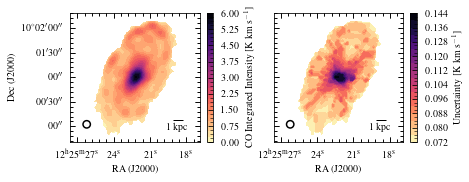

In [2]:
#
# Load CO integrated intensity (surface brightness) data
#
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # uncertainty
Ico_data, co_header = fits.getdata(Ico_path, header=True)
Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
co_wcs = WCS(co_header)
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
# Mask background
Ico_mask = (~np.isfinite(Ico_unc)) | (Ico_unc <= 0)
Ico_data[Ico_mask] = np.nan
Ico_unc[Ico_mask] = np.nan
# #
# # Plot (2 separate plots)
# #
# # Data
# fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
# img = ax.contourf(Ico_data, cmap="magma_r", levels=22, vmin=0)
# cbar = fig.colorbar(img)
# cbar.set_label(r"CO Integrated Intensity ($\rm K\; km\; s^{-1}$)")
# ax.set_aspect("equal")
# ax.set_xlabel("RA (J2000)")
# ax.set_ylabel("Dec (J2000)")
# ax.grid(False)
# plt.show()
# # Uncertainty
# fig, ax = plt.subplots(subplot_kw={"projection": co_wcs})
# img = ax.contourf(Ico_unc, cmap="magma_r", levels=22)
# cbar = fig.colorbar(img)
# cbar.set_label(r"CO Integrated Intensity Uncertainty ($\rm K\; km\; s^{-1}$)")
# ax.set_aspect("equal")
# ax.set_xlabel("RA (J2000)")
# ax.set_ylabel("Dec (J2000)")
# ax.grid(False)
# plt.show()
#
# Plot (1 plot)
#
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, subplot_kw={"projection": co_wcs}, sharey=True
)
# Data
img1 = ax1.contourf(Ico_data, cmap="magma_r", levels=22, vmin=0)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045)
cbar1.set_label(r"CO Integrated Intensity [$\rm K\; km\; s^{-1}$]")
ax1.set_aspect("equal")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
# Noise
img2 = ax2.contourf(Ico_unc, cmap="magma_r", levels=22)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045)
cbar2.set_label(r"Uncertainty [$\rm K\; km\; s^{-1}$]")
ax2.set_aspect("equal")
ax2.set_xlabel("RA (J2000)")
ax2.coords[1].set_ticklabel_visible(False)  # Hide y-axis tick label
ax2.grid(False)
# Add artists
pu.add_scalebar(ax1, co_wcs, dist=galdist)
pu.add_scalebar(ax2, co_wcs, dist=galdist)
pu.add_beam(ax1, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
pu.add_beam(ax2, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
# 
fig.tight_layout(pad=2)
# fig.savefig(galpath + f"{galaxy}_Kkms.pdf")
plt.show()

To convert from integrated intensity ($\rm k\, km\, s^{-1}$) to stellar mass density, we
apply Eq. (7) of Brown et al. (2021):

$$\rm \Sigma_{mol} = \frac{\alpha_{co}}{R_{21}} I_{CO}$$

where $\rm I_{CO}$ is the CO(1-0) line intensity (units of $\rm k\, km\, s^{-1}$),
$\rm \alpha_{CO}=4.35\, M_\odot\, pc^{-2} (K\, km\, s^{-1})^{-1}$ is the molecular gas mass
to CO(1-0) ratio (see Bolatto et al., 2013), and $R_{21}=0.8$ is the CO(2-1)/CO(1-0) line
ratio.

Note that molecular gas estimates derived using the formula above indicate the *total*
molecular gas mass (i.e., including the ~36% contribution of helium).

The following uses VERTICO's 9 arcsec beam, 2 arcsec pixels data, but this applies to other
data products, too (e.g., Nyquist resolution with 4 arcsec pixels)

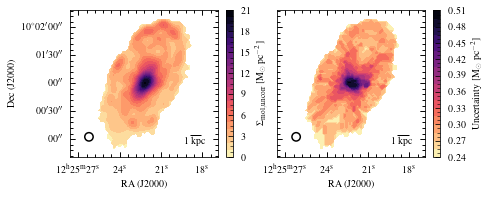

In [3]:
# 
# Convert to gas surface density
# 
alpha_co = 4.35  # M_sun/pc^2 per (K km/s)
R_21 = 0.8  # dimensionless. CO(2-1)/CO(1-0) ratio
gas_density_uncorr = alpha_co * R_21 * Ico_data
gas_density_err_uncorr = alpha_co * R_21 * Ico_unc
# 
# Plot
# 
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, subplot_kw={"projection": co_wcs}, sharey=True
)
# Data
img1 = ax1.contourf(gas_density_uncorr, cmap="magma_r", levels=22, vmin=0)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045)
cbar1.set_label(r"$\rm \Sigma_{mol, uncorr}$ [$\rm M_\odot\; pc^{-2}$]")
ax1.set_aspect("equal")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
# Noise
img2 = ax2.contourf(gas_density_err_uncorr, cmap="magma_r", levels=22)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045)
cbar2.set_label(r"Uncertainty [$\rm M_\odot\; pc^{-2}$]")
ax2.set_aspect("equal")
ax2.set_xlabel("RA (J2000)")
ax2.coords[1].set_ticklabel_visible(False)  # Hide y-axis tick label
ax2.grid(False)
# Add artists
pu.add_scalebar(ax1, co_wcs, dist=galdist)
pu.add_scalebar(ax2, co_wcs, dist=galdist)
pu.add_beam(ax1, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
pu.add_beam(ax2, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
# 
fig.tight_layout()
# fig.savefig(galpath + f"{galaxy}_gasDensity_uncorr.pdf")
plt.show()

Since CO is optically thick, we need to correct for the inclination when estimating the
gas mass since mass-to-light ratios assume the target is face-on. This allows us to make a
better "apples-to-apples" comparison. Note that we don't need to correct the inclination
for optical data since the stellar disk is optically thin (hence why we can see the
background galaxy in the optical plots below). We also do not correct the "raw" surface
brightness data (units of $\rm K\, km\, s^{-1}$) since these are our measurements.

To correct any quantity for inclination, simply multiply the quantity by the cosine of its
inclination ($i$). For example,

$$\mathrm{\Sigma_{mol, corr} = \Sigma_{mol}} \times \cos(i) =
\mathrm{\frac{\alpha_{co}}{R_{21}} I_{CO}} \times \cos(i)$$

If $i \geq i_{\rm threshold}$, then multiply by $i_{\rm threshold}$ instead. In Brown et al.
(2021), they use $i_{\rm threshold} = 80^\circ$


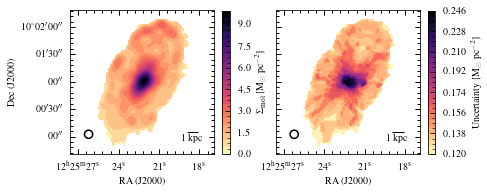

In [4]:
# 
# Correct for inclination
# 
inclination = 61  # degrees. From Table 1 of Brown et al. (2021)
gas_density = rpu.correct_for_i(
    gas_density_uncorr, inclination, i_threshold=80, i_replacement=80
)
gas_density_err = rpu.correct_for_i(
    gas_density_err_uncorr, inclination, i_threshold=80, i_replacement=80
)
# cos_i = np.cos(np.deg2rad(inclination))
# gas_density = gas_density_uncorr * cos_i
# gas_density_err = gas_density_err_uncorr * cos_i
# 
# Plot
# 
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, subplot_kw={"projection": co_wcs}, sharey=True
)
# Data
img1 = ax1.contourf(gas_density, cmap="magma_r", levels=22, vmin=0)
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045)
cbar1.set_label(r"$\rm \Sigma_{mol}$ [$\rm M_\odot\; pc^{-2}$]")
ax1.set_aspect("equal")
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
# Noise
img2 = ax2.contourf(gas_density_err, cmap="magma_r", levels=22)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045)
cbar2.set_label(r"Uncertainty [$\rm M_\odot\; pc^{-2}$]")
ax2.set_aspect("equal")
ax2.set_xlabel("RA (J2000)")
ax2.coords[1].set_ticklabel_visible(False)  # Hide y-axis tick label
ax2.grid(False)
# Add artists
pu.add_scalebar(ax1, co_wcs, dist=galdist)
pu.add_scalebar(ax2, co_wcs, dist=galdist)
pu.add_beam(ax1, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
pu.add_beam(ax2, co_header, xy=(10, 11), edgecolor="k", fc="None", lw=1.5, zorder=2)
# 
fig.tight_layout()
# fig.savefig(galpath + f"{galaxy}_gasDensity_corr.pdf")
plt.show()

# RGB Image

Produce a qualitative, median-normalized, log-scale RGB image for fun!


In [3]:
# Need to switch directories if using VS Code + sshfs
galaxy = "NGC4380"
galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
%cd "$galpath"
# 
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


<module 'plot_utils' from '/arc/home/IsaacCheng/coop_f2021/packages/plot_utils.py'>

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


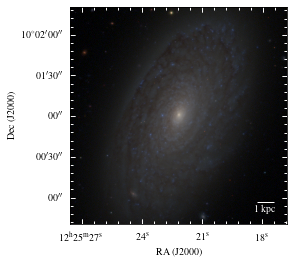

In [5]:
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
#
# Load data
# N.B. Need to update NGVS paths
# 
# 2 arcsec pixel CO data (purely to cutout optical data to match CO data)
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
# "red" channel (i-band)
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
# "green" channel (g-band)
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
# "blue" channel (u-band)
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
iband_data_uncut, iband_header_uncut = fits.getdata(iband_path, header=True)
gband_data_uncut, gband_header_uncut = fits.getdata(gband_path, header=True)
uband_data_uncut, uband_header_uncut = fits.getdata(uband_path, header=True)
# 
# Cutout optical data to extent of CO data (optional)
# 
iband_data, iband_wcs = fu.cutout_to_target(
    iband_data_uncut, WCS(iband_header_uncut), Ico_data, co_wcs
)
gband_data, gband_wcs = fu.cutout_to_target(
    gband_data_uncut, WCS(gband_header_uncut), Ico_data, co_wcs
)
uband_data, uband_wcs = fu.cutout_to_target(
    uband_data_uncut, WCS(uband_header_uncut), Ico_data, co_wcs
)
# 
# Median-normalize data on a logarithmic scale and make RGB array
# 
rgb_data = pu.lognorm_median(iband_data, gband_data, uband_data, a=1000, norm_factor=1000)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": uband_wcs})
ax.imshow(rgb_data, interpolation="none")
ax.tick_params(color="w")
pu.add_scalebar(ax, uband_wcs, dist=galdist, color="w")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
fig.savefig(galpath + f"{galaxy}_rgb.pdf")
plt.show()

# Major Axis Colour Profile

Generate a line profile (e.g., of the g-i colours) along the major axis of NGC 4380. The
function below uses nearest-neighbour sampling and *no smoothing is applied*. Finally,
note that the user must specify a start and end point. The `extend` keyword (which, if
given two points, automatically extends the line profile to the edges of the plot) is not
yet implemented!


In [1]:
# Need to switch directories if using VS Code + sshfs
galaxy = "NGC4380"
galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
%cd "$galpath"
# 
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


<module 'plot_utils' from '/arc/home/IsaacCheng/coop_f2021/packages/plot_utils.py'>

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/arc/home/IsaacCheng/coop_f2021/packages/fits_utils.py:267: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(blue / red)


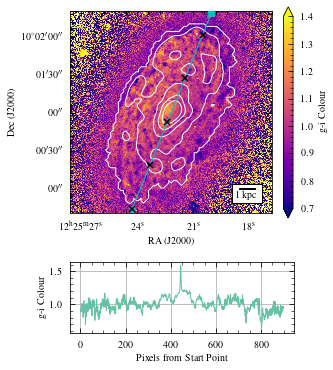

In [2]:
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
pa = 158  # position angle, degrees. From Table 1 of Brown et al. (2021)
          # N.B. pa starts at North and increases East (CCW)
#
# Load data
# N.B. Need to update NGVS paths
# 
# 2 arcsec pixel CO data (purely to cutout optical data to match CO data)
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
# Optical data
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
iband_data_uncut, iband_header_uncut = fits.getdata(iband_path, header=True)
gband_data_uncut, gband_header_uncut = fits.getdata(gband_path, header=True)
# 
# Cutout optical data to extent of CO data (optional)
# 
iband_data, iband_wcs = fu.cutout_to_target(
    iband_data_uncut, WCS(iband_header_uncut), Ico_data, co_wcs
)
gband_data, gband_wcs = fu.cutout_to_target(
    gband_data_uncut, WCS(gband_header_uncut), Ico_data, co_wcs
)
# 
# Calculate g-i colour
# 
gi_colour = fu.calc_colour(gband_data, iband_data)
# 
# Generate major axis profile
# 
start = np.array([264, 19])
direction = np.array([np.cos(np.deg2rad(pa + 90)), np.sin(np.deg2rad(pa + 90))]) * -1
num_px = 901
stop = np.array(direction * num_px + start).astype(int)
gi_profile, gi_profile_x, gi_profile_y = fu.line_profile(gi_colour, start, stop)
# 
# Plot
# 
fig = plt.figure(figsize=mpl.figure.figaspect(1.5))
# 
# Image of galaxy
# 
ax1 = fig.add_subplot(3, 1, (1, 2), projection=gband_wcs)
img1 = ax1.imshow(gi_colour, interpolation="none", cmap="plasma", vmin=0.7, vmax=1.4)
cbar1 = fig.colorbar(img1, fraction=0.045, extend="both")
cbar1.set_label("g-i Colour")
# Add CO contour
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=range(5),
    colors="w",
    linewidths=1,
)
# Add line showing line profile
ax1.plot(gi_profile_x, gi_profile_y, "c-", lw=1)
ax1.plot(*start, "co", label="Start")  # circle
ax1.plot(*stop, "cs", label="End")  # square
# Tick marks along line
ax1.plot(
    gi_profile_x[::200], gi_profile_y[::200], "kx", markersize=6, markeredgewidth=1.5
)
# 
pu.add_scalebar(ax1, gband_wcs, dist=galdist, frameon=True, pad=0.4, borderpad=1)
ax1.set_xlabel("RA (J2000)")
ax1.set_ylabel("Dec (J2000)")
ax1.grid(False)
# 
# Line profile
# 
ax2 = fig.add_subplot(414)
ax2.plot(gi_profile, lw=1)
ax2.set_ylabel("g-i Colour")
ax2.set_xlabel("Pixels from Start Point")
# 
# fig.savefig(galpath + f"{galaxy}_gi_profile.pdf")
plt.show()

# Bin NGVS Data (1. to specific extent & resolution, 2. using adaptive binning)


In [1]:
# Need to switch directories if using VS Code + sshfs
galaxy = "NGC4380"
galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
%cd "$galpath"
# 
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import reproject
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


<module 'plot_utils' from '/arc/home/IsaacCheng/coop_f2021/packages/plot_utils.py'>

## 1. Regular binning procedure

1. Cut out the optical data to the radio data's extent. Remember to modify the WCS object.
2. Reproject the optical image (while preserving flux) so that its dimensions are integer
   multiples of the radio data's dimensions. Furthermore, the new dimensions should
   satisfy the above criterion while being as close as possible to the cutout's original
   dimensions. (This is because reprojection tries to preserve the pixel values as much as
   possible, regardless of the new dimensions.) Remember to modify the WCS object
   (tricky!).
3. Bin the reprojected optical image to the same resolution as the radio data. Remember to
   modify the WCS object (which should now be identical to the radio data's WCS object).

### Nyquist (4 arcsec pixels) resolution


In [2]:
bin_resolution = "nyquist"
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
# 
# Load data
# N.B. Need to update NGVS paths
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# Mask (flag maps)
zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
zband_data_full, zband_header_full = fits.getdata(zband_path, header=True)
iband_data_full, iband_header_full = fits.getdata(iband_path, header=True)
gband_data_full, gband_header_full = fits.getdata(gband_path, header=True)
uband_data_full, uband_header_full = fits.getdata(uband_path, header=True)
# Noise
zband_noise_full = fits.getdata(znoise_path)
iband_noise_full = fits.getdata(inoise_path)
gband_noise_full = fits.getdata(gnoise_path)
uband_noise_full = fits.getdata(unoise_path)
# Masks
zband_good_full = fits.getdata(zgood_path, ext=1)
iband_good_full = fits.getdata(igood_path, ext=1)
gband_good_full = fits.getdata(ggood_path, ext=1)
uband_good_full = fits.getdata(ugood_path, ext=1)
# 
# VERTICO CO Data
# 
# Nyquist resolution. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_Kkms-1.fits"
# Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/nyquistPix/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_np_round_mom0_unc.fits"  # uncertainty
Ico_data, co_header = fits.getdata(Ico_path, header=True)
# Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
co_wcs = WCS(co_header)
#
# Mask the data and noise arrays
#
my_mask = np.zeros_like(uband_data_full).astype(bool)
my_mask[2035:2050, 2690:2705] = True  # mask single star near top of VCC 792
my_mask[1156:1187, 2685:2715] = True  # mask single star near bottom of VCC 792
uband_data_masked = np.ma.masked_array(uband_data_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
uband_noise_masked = np.ma.masked_array(uband_noise_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_data_masked = np.ma.masked_array(gband_data_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_noise_masked = np.ma.masked_array(gband_noise_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_data_masked = np.ma.masked_array(iband_data_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_noise_masked = np.ma.masked_array(iband_noise_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_data_masked = np.ma.masked_array(zband_data_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_noise_masked = np.ma.masked_array(zband_noise_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)

u-band data


In [9]:
%matplotlib widget
plt.close("all")
# 
# Bin u-band NGVS data to VERTICO resolution
# 
(
    uband_xs_binned,
    uband_ys_binned,
    uband_data_binned,
    uband_noise_binned,
    uband_isgood_binned,
    uband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    uband_data_masked,
    WCS(uband_header_full),
    uband_noise_masked,
    WCS(uband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
uband_abs_mag_binned, uband_abs_mag_err_binned = fu.calc_mag(
    uband_data_binned, uband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(uband_data_binned/uband_noise_binned), uband_wcs_binned,
                        Ico_data, co_wcs, vmin=150, vmax=1250, title="u-band SNR")
pu._plot_regBin_results(uband_abs_mag_binned, uband_wcs_binned,
                        Ico_data, co_wcs, title="u-band Absolute Magnitude")
# 
# Pickle data
# 
uband_outfile = galpath + f"{galaxy}_regBin_uband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    uband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    uband_xs_binned,
    uband_ys_binned,
    uband_data_binned,
    uband_noise_binned,
    uband_abs_mag_binned,
    uband_abs_mag_err_binned,
    uband_isgood_binned,
    uband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_uband_nyquist.pkl
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_uband_nyquist.pkl


g-band data


In [10]:
%matplotlib widget
plt.close("all")
# 
# Bin g-band NGVS data to VERTICO resolution
# 
(
    gband_xs_binned,
    gband_ys_binned,
    gband_data_binned,
    gband_noise_binned,
    gband_isgood_binned,
    gband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    gband_data_masked,
    WCS(gband_header_full),
    gband_noise_masked,
    WCS(gband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
gband_abs_mag_binned, gband_abs_mag_err_binned = fu.calc_mag(
    gband_data_binned, gband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(gband_data_binned/gband_noise_binned), gband_wcs_binned,
                        Ico_data, co_wcs, vmin=400, vmax=3000, title="g-band SNR")
pu._plot_regBin_results(gband_abs_mag_binned, gband_wcs_binned,
                        Ico_data, co_wcs, title="g-band Absolute Magnitude")
# 
# Pickle data
# 
gband_outfile = galpath + f"{galaxy}_regBin_gband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    gband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    gband_xs_binned,
    gband_ys_binned,
    gband_data_binned,
    gband_noise_binned,
    gband_abs_mag_binned,
    gband_abs_mag_err_binned,
    gband_isgood_binned,
    gband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_gband_nyquist.pkl


i-band data


In [11]:
%matplotlib widget
plt.close("all")
# 
# Bin i-band NGVS data to VERTICO resolution
# 
(
    iband_xs_binned,
    iband_ys_binned,
    iband_data_binned,
    iband_noise_binned,
    iband_isgood_binned,
    iband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    iband_data_masked,
    WCS(iband_header_full),
    iband_noise_masked,
    WCS(iband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
iband_abs_mag_binned, iband_abs_mag_err_binned = fu.calc_mag(
    iband_data_binned, iband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(iband_data_binned/iband_noise_binned), iband_wcs_binned,
                        Ico_data, co_wcs, vmin=300, vmax=3000, title="i-band SNR")
pu._plot_regBin_results(iband_abs_mag_binned, iband_wcs_binned,
                        Ico_data, co_wcs, title="i-band Absolute Magnitude")
# 
# Pickle data
# 
iband_outfile = galpath + f"{galaxy}_regBin_iband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    iband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    iband_xs_binned,
    iband_ys_binned,
    iband_data_binned,
    iband_noise_binned,
    iband_abs_mag_binned,
    iband_abs_mag_err_binned,
    iband_isgood_binned,
    iband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_iband_nyquist.pkl


z-band data


In [12]:
%matplotlib widget
plt.close("all")
# 
# Bin z-band NGVS data to VERTICO resolution
# 
(
    zband_xs_binned,
    zband_ys_binned,
    zband_data_binned,
    zband_noise_binned,
    zband_isgood_binned,
    zband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    zband_data_masked,
    WCS(zband_header_full),
    zband_noise_masked,
    WCS(zband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
zband_abs_mag_binned, zband_abs_mag_err_binned = fu.calc_mag(
    zband_data_binned, zband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(zband_data_binned/zband_noise_binned), zband_wcs_binned,
                        Ico_data, co_wcs, vmin=300, vmax=3000, title="z-band SNR")
pu._plot_regBin_results(zband_abs_mag_binned, zband_wcs_binned,
                        Ico_data, co_wcs, title="z-band Absolute Magnitude")
# 
# Pickle data
# 
zband_outfile = galpath + f"{galaxy}_regBin_zband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    zband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    zband_xs_binned,
    zband_ys_binned,
    zband_data_binned,
    zband_noise_binned,
    zband_abs_mag_binned,
    zband_abs_mag_err_binned,
    zband_isgood_binned,
    zband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_zband_nyquist.pkl


Export absolute magnitudes to text file for SED fitting


In [20]:
# 
# Export data to text file
# 
abs_mag_outfile = galpath + f"{galaxy}_regBin_absMag_{bin_resolution}.txt"
# # 
# # If the data are still in the notebook session:
# # 
# fu._txt_mags(
#     abs_mag_outfile,
#     uband_xs_binned,
#     uband_ys_binned,
#     uband_abs_mag_binned,
#     uband_abs_mag_err_binned,
#     gband_abs_mag_binned,
#     gband_abs_mag_err_binned,
#     iband_abs_mag_binned,
#     iband_abs_mag_err_binned,
#     zband_abs_mag_binned,
#     zband_abs_mag_err_binned,
# )
# 
# If the data are from pickle files (i.e., the pickle files generated in the cells above):
#   Remember to run the first cell in the "Bin NGVS Data (1. to specific extent &
#   resolution, 2. using adaptive binning)" section and the first cell in the "Nyquist (4
#   arcsec pixels) resolution" subsubsection
# 
fu._txt_mags_from_pkl(galpath, galaxy, bin_resolution, abs_mag_outfile)


Saved /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_absMag_nyquist.txt


### 2 arcsec pixels + 9 arcsec beam resolution


In [2]:
bin_resolution = "9as"  # technically 2 arcsec pixels with 9 arcsec beam
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
# 
# Load data
# N.B. Need to update NGVS paths
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# Mask (flag maps)
zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
zband_data_full, zband_header_full = fits.getdata(zband_path, header=True)
iband_data_full, iband_header_full = fits.getdata(iband_path, header=True)
gband_data_full, gband_header_full = fits.getdata(gband_path, header=True)
uband_data_full, uband_header_full = fits.getdata(uband_path, header=True)
# Noise
zband_noise_full = fits.getdata(znoise_path)
iband_noise_full = fits.getdata(inoise_path)
gband_noise_full = fits.getdata(gnoise_path)
uband_noise_full = fits.getdata(unoise_path)
# Masks
zband_good_full = fits.getdata(zgood_path, ext=1)
iband_good_full = fits.getdata(igood_path, ext=1)
gband_good_full = fits.getdata(ggood_path, ext=1)
uband_good_full = fits.getdata(ugood_path, ext=1)
# 
# VERTICO CO Data
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
# Ico_unc_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_unc.fits"  # uncertainty
Ico_data, co_header = fits.getdata(Ico_path, header=True)
# Ico_unc = fits.getdata(Ico_unc_path)  # uncertainty
co_wcs = WCS(co_header)
#
# Mask the data and noise arrays
#
my_mask = np.zeros_like(uband_data_full).astype(bool)
my_mask[2035:2050, 2690:2705] = True  # mask single star near top of VCC 792
my_mask[1156:1187, 2685:2715] = True  # mask single star near bottom of VCC 792
uband_data_masked = np.ma.masked_array(uband_data_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
uband_noise_masked = np.ma.masked_array(uband_noise_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_data_masked = np.ma.masked_array(gband_data_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_noise_masked = np.ma.masked_array(gband_noise_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_data_masked = np.ma.masked_array(iband_data_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_noise_masked = np.ma.masked_array(iband_noise_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_data_masked = np.ma.masked_array(zband_data_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_noise_masked = np.ma.masked_array(zband_noise_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)

u-band data


In [3]:
%matplotlib widget
plt.close("all")
# 
# Bin u-band NGVS data to VERTICO resolution
# 
(
    uband_xs_binned,
    uband_ys_binned,
    uband_data_binned,
    uband_noise_binned,
    uband_isgood_binned,
    uband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    uband_data_masked,
    WCS(uband_header_full),
    uband_noise_masked,
    WCS(uband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
uband_abs_mag_binned, uband_abs_mag_err_binned = fu.calc_mag(
    uband_data_binned, uband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(uband_data_binned/uband_noise_binned), uband_wcs_binned,
                        Ico_data, co_wcs, vmin=10, vmax=800, title="u-band SNR")
pu._plot_regBin_results(uband_abs_mag_binned, uband_wcs_binned,
                        Ico_data, co_wcs, title="u-band Absolute Magnitude")
# 
# Pickle data
# 
uband_outfile = galpath + f"{galaxy}_regBin_uband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    uband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    uband_xs_binned,
    uband_ys_binned,
    uband_data_binned,
    uband_noise_binned,
    uband_abs_mag_binned,
    uband_abs_mag_err_binned,
    uband_isgood_binned,
    uband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_uband_9as.pkl


g-band data


In [4]:
%matplotlib widget
plt.close("all")
# 
# Bin g-band NGVS data to VERTICO resolution
# 
(
    gband_xs_binned,
    gband_ys_binned,
    gband_data_binned,
    gband_noise_binned,
    gband_isgood_binned,
    gband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    gband_data_masked,
    WCS(gband_header_full),
    gband_noise_masked,
    WCS(gband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
gband_abs_mag_binned, gband_abs_mag_err_binned = fu.calc_mag(
    gband_data_binned, gband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(gband_data_binned/gband_noise_binned), gband_wcs_binned,
                        Ico_data, co_wcs, vmin=500, vmax=2000, title="g-band SNR")
pu._plot_regBin_results(gband_abs_mag_binned, gband_wcs_binned,
                        Ico_data, co_wcs, title="g-band Absolute Magnitude")
# 
# Pickle data
# 
gband_outfile = galpath + f"{galaxy}_regBin_gband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    gband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    gband_xs_binned,
    gband_ys_binned,
    gband_data_binned,
    gband_noise_binned,
    gband_abs_mag_binned,
    gband_abs_mag_err_binned,
    gband_isgood_binned,
    gband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_gband_9as.pkl


i-band data


In [5]:
%matplotlib widget
plt.close("all")
# 
# Bin i-band NGVS data to VERTICO resolution
# 
(
    iband_xs_binned,
    iband_ys_binned,
    iband_data_binned,
    iband_noise_binned,
    iband_isgood_binned,
    iband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    iband_data_masked,
    WCS(iband_header_full),
    iband_noise_masked,
    WCS(iband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
iband_abs_mag_binned, iband_abs_mag_err_binned = fu.calc_mag(
    iband_data_binned, iband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(iband_data_binned/iband_noise_binned), iband_wcs_binned,
                        Ico_data, co_wcs, vmin=300, vmax=2000, title="i-band SNR")
pu._plot_regBin_results(iband_abs_mag_binned, iband_wcs_binned,
                        Ico_data, co_wcs, title="i-band Absolute Magnitude")
# 
# Pickle data
# 
iband_outfile = galpath + f"{galaxy}_regBin_iband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    iband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    iband_xs_binned,
    iband_ys_binned,
    iband_data_binned,
    iband_noise_binned,
    iband_abs_mag_binned,
    iband_abs_mag_err_binned,
    iband_isgood_binned,
    iband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_iband_9as.pkl


z-band data


In [6]:
%matplotlib widget
plt.close("all")
# 
# Bin z-band NGVS data to VERTICO resolution
# 
(
    zband_xs_binned,
    zband_ys_binned,
    zband_data_binned,
    zband_noise_binned,
    zband_isgood_binned,
    zband_wcs_binned,
) = fu.bin_sn_arrs_to_target(
    zband_data_masked,
    WCS(zband_header_full),
    zband_noise_masked,
    WCS(zband_header_full),
    Ico_data,
    co_wcs,
    reproject_func=reproject.reproject_exact,
    bin_func=np.nansum,
    print_debug=False,
)
# Calculate absolute AB magnitudes
zband_abs_mag_binned, zband_abs_mag_err_binned = fu.calc_mag(
    zband_data_binned, zband_noise_binned,
    zpt=30.0, calc_abs=True, dist=galdist.to(u.pc).value)
# 
# Check results
# 
pu._plot_regBin_results(abs(zband_data_binned/zband_noise_binned), zband_wcs_binned,
                        Ico_data, co_wcs, vmin=200, vmax=1500, title="z-band SNR")
pu._plot_regBin_results(zband_abs_mag_binned, zband_wcs_binned,
                        Ico_data, co_wcs, title="z-band Absolute Magnitude")
# 
# Pickle data
# 
zband_outfile = galpath + f"{galaxy}_regBin_zband_{bin_resolution}.pkl"
fu._dill_regBin_results(
    zband_outfile,
    "reproject_exact",
    galdist.to(u.pc).value,
    zband_xs_binned,
    zband_ys_binned,
    zband_data_binned,
    zband_noise_binned,
    zband_abs_mag_binned,
    zband_abs_mag_err_binned,
    zband_isgood_binned,
    zband_wcs_binned,
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_zband_9as.pkl


Export absolute magnitudes to text file for SED fitting


In [7]:
# 
# Export data to text file
# 
abs_mag_outfile = galpath + f"{galaxy}_regBin_absMag_{bin_resolution}.txt"
# # 
# # If the data are still in the notebook session:
# # 
# fu._txt_mags(
#     abs_mag_outfile,
#     uband_xs_binned,
#     uband_ys_binned,
#     uband_abs_mag_binned,
#     uband_abs_mag_err_binned,
#     gband_abs_mag_binned,
#     gband_abs_mag_err_binned,
#     iband_abs_mag_binned,
#     iband_abs_mag_err_binned,
#     zband_abs_mag_binned,
#     zband_abs_mag_err_binned,
# )
# 
# If the data are from pickle files (i.e., the pickle files generated in the cells above):
#   Remember to run the first cell in the "Bin NGVS Data (1. to specific extent &
#   resolution, 2. using adaptive binning)" section and the first cell in the "2 arcsec
#   pixels + 9 arcsec beam resolution" subsubsection
# 
fu._txt_mags_from_pkl(galpath, galaxy, bin_resolution, abs_mag_outfile)


Saved /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_regBin_absMag_9as.txt


## 2. Voronoi (adaptive) binning procedure

The difficulty lies in:
1. Ensuring the *exact same* Voronoi binning pattern occurs across all optical bands
2. Reducing the runtime of Voronoi binning for large images

Here is a basic 4-step method that aims to solve item 1 above:
1. Choose a target SNR (e.g., target_snr=50) and run Voronoi binning on one file. Call the
   resulting binning "bin0".
2. Apply the same Voronoi binning (bin0) to the other band(s). If all of the pixels have
   an SNR > target_snr, we are done.
3. If not all the pixels meet the required SNR, re-run Voronoi binning with
   target_snr=target_snr + (some value). That is, we are increasing the target SNR by
   some value. Call the resulting binning "bin1".
4. Apply this new Voronoi binning to the other band(s). If all the pixels have an SNR >
   the original target_snr (e.g., 50), we are done. Else, repeat steps 3 & 4.
   - In principle, this is easy. In testing, despite setting a target_snr of 30, for
     example, many points (not near the edges) will have SNRs of ~25 as well. Thus, this
     may require a manual check. Also see the 2 strategies below.

There are 2 easy strategies to help speed up the 4-step method above:
1. Choose an initial target_snr greater than the SNR we really want/need (e.g., setting a
   target_snr=35 when we need a minimum SNR of 30). Once an automated function is
   implemented, we could take these inputs as two different parameters (e.g.,
   initial_snr=35 and wanted_snr=30) in an attempt to minimize the number of Voronoi
   binning iterations. Another approach instead of naively checking if all SNR >
   target_snr is by allowing some percentage (e.g., 1%) of pixels to lie below the
   target_snr and still count this as a success.
2. Run Voronoi binning on the image that has the lowest SNR (e.g., u- or z-band data).
   This will help maximize the chance that all the other bands meet the target_snr using
   the same Voronoi binning pattern.

Regarding difficulty #2, here is an excerpt from the `vorbin` documentation (slightly
modified for myself):
> As for many other computational problems, a way to radically decrease the computation
> time consists of proceeding in a hierarchical manner. Suppose for example we have a
> 4000x4000 pixel image, we can do the following:
>> 1. Rebin the image regularly (e.g. in groups of 8x8 pixels) to a manageable size of
>>    500x500 pixels;
>> 2. Apply the standard Voronoi 2D-binning procedure to the 500x500 image;
>> 3. Transform all unbinned pixels (which already have enough S/N) of the 500x500 Voronoi
>>    2D-binned image back into their original individual full-resolution pixels;
>> 4. Now apply Voronoi 2D-binning only to the connected regions of full-resolution
>>    pixels (i.e., the "subpixels" of step 2's unbinned pixels);
>> 5. Merge the set of lower resolution bins with the higher resolution ones.

In practice, I still have to write a function to do this. I did not bother to do it with
the current galaxy since I just let Voronoi binning run overnight.


In [17]:
bin_resolution = "vorbin"
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty
# 
# Load data
# N.B. Need to update NGVS paths
# 
# Signal
zband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.3136_8588_6905_10184.fits"
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
znoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.sig.3136_8588_6905_10184.fits"
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# Mask (flag maps)
zgood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.z.Mg004.flag.3136_8588_6905_10184.fits"
igood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.flag.3136_8588_6905_10184.fits"
ggood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.flag.3136_8588_6905_10184.fits"
ugood_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.flag.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
zband_data_full, zband_header_full = fits.getdata(zband_path, header=True)
iband_data_full, iband_header_full = fits.getdata(iband_path, header=True)
gband_data_full, gband_header_full = fits.getdata(gband_path, header=True)
uband_data_full, uband_header_full = fits.getdata(uband_path, header=True)
# Noise
zband_noise_full = fits.getdata(znoise_path)
iband_noise_full = fits.getdata(inoise_path)
gband_noise_full = fits.getdata(gnoise_path)
uband_noise_full = fits.getdata(unoise_path)
# Masks
zband_good_full = fits.getdata(zgood_path, ext=1)
iband_good_full = fits.getdata(igood_path, ext=1)
gband_good_full = fits.getdata(ggood_path, ext=1)
uband_good_full = fits.getdata(ugood_path, ext=1)
# 
# VERTICO CO Data (only to cut out the NGVS data to the same extent as the VERTICO data)
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)
#
# Mask the data and noise arrays
#
my_mask = np.zeros_like(uband_data_full).astype(bool)
my_mask[2035:2050, 2690:2705] = True  # mask single star near top of VCC 792
my_mask[1156:1187, 2685:2715] = True  # mask single star near bottom of VCC 792
uband_data_masked = np.ma.masked_array(uband_data_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
uband_noise_masked = np.ma.masked_array(uband_noise_full, mask=(uband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_data_masked = np.ma.masked_array(gband_data_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
gband_noise_masked = np.ma.masked_array(gband_noise_full, mask=(gband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_data_masked = np.ma.masked_array(iband_data_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
iband_noise_masked = np.ma.masked_array(iband_noise_full, mask=(iband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_data_masked = np.ma.masked_array(zband_data_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
zband_noise_masked = np.ma.masked_array(zband_noise_full, mask=(zband_good_full == 0) | my_mask).filled(fill_value=np.nan)
# 
# Cutout the data and noise to the same extent as the VERTICO data
# 
uband_data, uband_wcs = fu.cutout_to_target(uband_data_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_data, gband_wcs = fu.cutout_to_target(gband_data_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_data, iband_wcs = fu.cutout_to_target(iband_data_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_data, zband_wcs = fu.cutout_to_target(zband_data_masked, WCS(zband_header_full), Ico_data, co_wcs)
uband_noise, uband_wcs = fu.cutout_to_target(uband_noise_masked, WCS(uband_header_full), Ico_data, co_wcs)
gband_noise, gband_wcs = fu.cutout_to_target(gband_noise_masked, WCS(gband_header_full), Ico_data, co_wcs)
iband_noise, iband_wcs = fu.cutout_to_target(iband_noise_masked, WCS(iband_header_full), Ico_data, co_wcs)
zband_noise, zband_wcs = fu.cutout_to_target(zband_noise_masked, WCS(zband_header_full), Ico_data, co_wcs)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Execute Voronoi binning and save inputs + raw outputs


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Reference data array shape: (862, 861)
/arc/home/IsaacCheng/coop_f2021/warmup/voronoi_debug3.pdf - Saved!
It took 126.07532470623651 minutes to complete Voronoi binning.
Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_In+Out.pkl


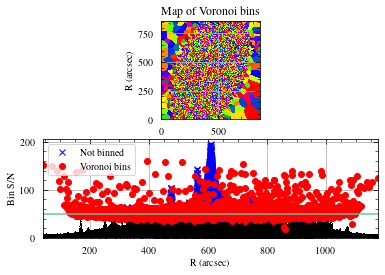

In [3]:
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import dill
import time  # to see how long Voronoi binning takes
# 
# Specify reference arrays for Voronoi binning.
# The resulting binning pattern will be applied across all bands
# 
ref_data = uband_data
ref_noise = uband_noise
ref_wcs = uband_wcs
print("Reference data array shape:", np.shape(ref_data))
# 
# Voronoi binning preparation
# 
snr_target = 50
#
y_coords, x_coords = np.meshgrid(
    np.arange(ref_data.shape[0]), np.arange(ref_data.shape[1])
)
x_coords, y_coords = x_coords.T, y_coords.T
isgood_vorbin = np.isfinite(ref_data) & np.isfinite(ref_noise)
# 
# Voronoi binning of reference data and noise
# 
starttime = time.time()
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
    x_coords[isgood_vorbin],
    y_coords[isgood_vorbin],
    ref_data[isgood_vorbin],
    ref_noise[isgood_vorbin],
    targetSN=snr_target,
    pixelsize=1,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
)
endtime = time.time()
timediff = endtime - starttime  # seconds
print("It took", timediff / 60, "minutes to complete Voronoi binning.")
# 
# Save inputs and raw outputs of Voronoi binning
# 
vorbin_outfile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_In+Out.pkl"
with open(vorbin_outfile, "wb") as f:
    dill.dump(
        {
            # "full_shape": np.shape(data_u_cut),  # same as isgood_vorbin.shape
            "x_coords": x_coords,
            "y_coords": y_coords,
            "signal": ref_data,
            "noise": ref_noise,
            "isgood_vorbin": isgood_vorbin,
            "snr_target": snr_target,
            "binNum": binNum,
            "xNode": xNode,
            "yNode": yNode,
            "xBar": xBar,
            "yBar": yBar,
            "sn": sn,
            "nPixels": nPixels,
            "scale": scale,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
        },
        f,
    )
print(f"Pickled {vorbin_outfile}")

Process outputs so they are more usable. Save results


In [7]:
#
# Assign each pixel to its Voronoi bin. Note that we cannot simply reshape the array since
# there are holes in our input data!
#
binNum_arr = np.zeros(ref_data.shape) * np.nan
for i, (x, y) in enumerate(zip(x_coords[isgood_vorbin], y_coords[isgood_vorbin])):
    binNum_arr[y, x] = binNum[i]  # binNum has same length as coords
#
# Bin the data and noise according to the Voronoi bins
#
uband_data_vorbinned = np.zeros(uband_data.shape) * np.nan
gband_data_vorbinned = np.zeros(gband_data.shape) * np.nan
iband_data_vorbinned = np.zeros(iband_data.shape) * np.nan
zband_data_vorbinned = np.zeros(zband_data.shape) * np.nan
uband_noise_vorbinned = np.zeros(uband_noise.shape) * np.nan
gband_noise_vorbinned = np.zeros(gband_noise.shape) * np.nan
iband_noise_vorbinned = np.zeros(iband_noise.shape) * np.nan
zband_noise_vorbinned = np.zeros(zband_noise.shape) * np.nan
px_per_bin = np.zeros(uband_data.shape) * np.nan  # all data/noise should have same shape
for i in np.unique(binNum):
    bin_idx = binNum_arr == i  # all of these pixels are in the same bin
    uband_data_vorbinned[bin_idx], uband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        uband_data[bin_idx], uband_noise[bin_idx], func=np.nansum
    )
    gband_data_vorbinned[bin_idx], gband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        gband_data[bin_idx], gband_noise[bin_idx], func=np.nansum
    )
    iband_data_vorbinned[bin_idx], iband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        iband_data[bin_idx], iband_noise[bin_idx], func=np.nansum
    )
    zband_data_vorbinned[bin_idx], zband_noise_vorbinned[bin_idx] = fu.calc_tot_sn(
        zband_data[bin_idx], zband_noise[bin_idx], func=np.nansum
    )
    px_per_bin[bin_idx] = nPixels[i]
# 
# Pickle the results
# 
vorbinned_results_outfile = galpath + f"{galaxy}_vorbin_SNR{snr_target}_ugizBinned.pkl"
with open(vorbinned_results_outfile, "wb") as f:
    dill.dump(
        {
            "x_coords": x_coords,
            "y_coords": y_coords,
            "wcs": ref_wcs,
            "wcs_array_shape": ref_wcs.array_shape,
            "uband_signal": uband_data_vorbinned,
            "uband_noise": uband_noise_vorbinned,
            "gband_signal": gband_data_vorbinned,
            "gband_noise": gband_noise_vorbinned,
            "iband_signal": iband_data_vorbinned,
            "iband_noise": iband_noise_vorbinned,
            "zband_signal": zband_data_vorbinned,
            "zband_noise": zband_noise_vorbinned,
            "snr_target": snr_target,  # float or int
            "px_per_bin": px_per_bin,  # 2D array with same shape as coords/signal/noise
            "binNum": binNum,  # 1D array returned by vorbin. Only contains "good" pixels
            "binNum_arr": binNum_arr,  # 2D array with same shape as coords/signal/noise
        },
        f,
    )
print(f"Pickled {vorbinned_results_outfile}")


Pickled /arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380/NGC4380_vorbin_SNR50_ugizBinned.pkl


# Stellar Mass Maps


In [2]:
# Need to switch directories if using VS Code + sshfs
galaxy = "NGC4380"
galpath = f"/arc/home/IsaacCheng/coop_f2021/galaxies/{galaxy}/"
%cd "$galpath"
# 
import astropy.units as u
import dill
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
# Reload my packages
import importlib
importlib.reload(fu)
importlib.reload(pu)
# 
galdist = 16.5 * u.Mpc  # distance to centre of Virgo cluster. Assume 10% uncertainty

/arc/home/IsaacCheng/coop_f2021/galaxies/NGC4380


## Nyquist (4 arcsec pixels) resolution


In [ ]:
#
# Load SED fitting results
# 


## 2 arcsec pixels + 9 arcsec beam resolution


## High resolution (Voronoi binning)


### Mass-to-Light vs. Colour Relation (Taylor et al., 2011)

Estimate the mass-to-light ratio (and luminosity + stellar mass density) of the galaxy
using g-i colours and i-band fluxes.

Following Eq. (7) of Taylor et al. (2011), the mass-to-light ($M_\star/L_i$) ratio can be
estimated using:

$$ \log(M_\star/L_i) = 0.70 \times (g-i) - 0.68 $$

where $(g-i)$ are the g-i colours.

The i-band luminosity of the data in solar units ($L_i$) can be calculated using:

$$\log(L_i\, [L_{i,\odot}]) = -0.4 \times (\mathrm{M}_i - \mathrm{M}_{i, \odot})$$

where $\mathrm{M}_i$ are the absolute i-band AB magnitudes of the data and
$\mathrm{M}_{i,\odot}=4.58$ is the absolute i-band AB magnitude of the Sun. Notice that a
more negative $\mathrm{M}_i$ directly leads to a higher $L_i$ estimate.

Combining the two equations above, we arrive at the following equation that gives an
estimate of the stellar mass ($M_\star$) in units of solar masses (N.B. $M$ vs.
$\mathrm{M}$):

$$\log(M_\star\; [M_\odot]) = 0.70 \times (g-i) - 0.68 + \log(L_i) = 0.70 \times (g-i) - 0.4 \times \mathrm{M}_i + 1.152 $$

This is Eq. (8) of Taylor et al. (2011).

Finally, note that this formula (i.e., Eq. (7) and therefore also Eq. (8)) was empirically
derived and assumes a simple exponentially-decreasing stellar disk.


In [30]:
snr_target = 50  # specifies which voronoi binning file to use
#
# Load data
#
vorbin_results = galpath + f"{galaxy}_vorbin_SNR{snr_target}_ugizBinned.pkl"
with open(vorbin_results, "rb") as f:
    file = dill.load(f)
    gband_signal = file["gband_signal"]
    gband_noise = file["gband_noise"]
    iband_signal = file["iband_signal"]
    iband_noise = file["iband_noise"]
    vorbin_wcs = file["wcs"]
    vorbin_wcs.array_shape = file["wcs_array_shape"]
    px_per_bin = file["px_per_bin"]
#
# Calculate quantities
#
results, errors = fu.MLi_taylor2011(
    gband_signal,
    iband_signal,
    galdist,
    vorbin_wcs,
    gband_err=gband_noise,
    iband_err=iband_noise,
    px_per_bin=px_per_bin,
)
avg_iband_abs_mag, gi_colour, Li, MLi_ratio, M, M_density = results
avg_iband_abs_mag_err, gi_colour_err, Li_err, MLi_ratio_err, M_err, M_density_err = errors
# 
# Load VERTICO data (for contours)
# 
# 9 arcsec beam, 2 arcsec pixels. Units of K.km/s
Ico_path = f"/arc/home/IsaacCheng/coop_f2021/vertico_data/v1.3/9arcsec/{galaxy}/{galaxy}_7m+tp_co21_pbcorr_9as_round_mom0_Kkms-1.fits"
Ico_data, co_header = fits.getdata(Ico_path, header=True)
co_wcs = WCS(co_header)


In [31]:
print(vorbin_wcs)
print(co_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 186.118063  10.10978557  
CRPIX : 4711.0  2232.0  
PC1_1 PC1_2  : -5.160914588e-05  0.0  
PC2_1 PC2_2  : 0.0  5.160914588e-05  
CDELT : 1.0  1.0  
NAXIS : 861  862
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 186.3430641667  10.01666666667  
CRPIX : 39.75  40.75  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0005555555555556  0.0005555555555556  
NAXIS : 80  80


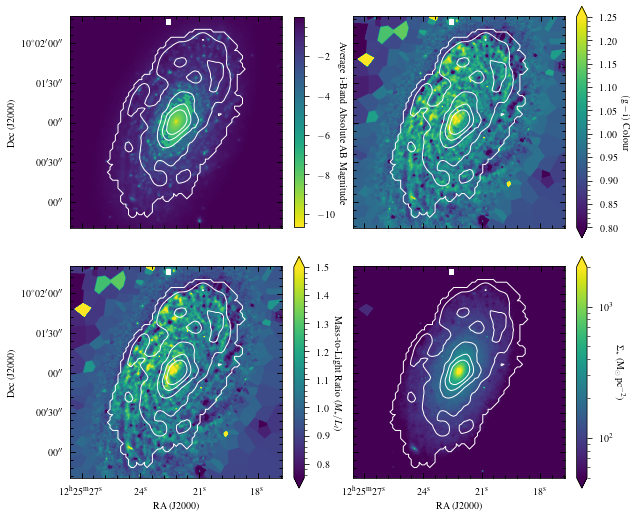

In [33]:
# 
# Plot
# 
%matplotlib inline
plt.close("all")
# 
cmap = "viridis"
fig, axs = plt.subplots(2, 2, figsize=(8, 7.25), subplot_kw={"projection": vorbin_wcs})
ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# 
# Average i-band absolute AB magnitudes
# 
img1 = ax1.imshow(avg_iband_abs_mag, cmap=cmap + "_r")
cbar1 = fig.colorbar(img1, ax=ax1, fraction=0.045)
cbar1.ax.tick_params(which="both", direction="out")
cbar1.set_label("Average i-Band Absolute AB Magnitude", rotation=270, labelpad=12)
cbar1.ax.yaxis.set_offset_position("left")
ax1.contour(
    Ico_data,
    transform=ax1.get_transform(co_wcs),
    levels=range(5),
    colors="w",
    linewidths=1,
    zorder=10,
)
ax1.set_ylabel("Dec (J2000)")
ax1.coords[0].set_ticklabel_visible(False)
ax1.grid(False)
ax1.set_aspect("equal")
# 
# g-i colours
# 
img2 = ax2.imshow(gi_colour, cmap=cmap, vmin=0.8, vmax=1.25)
cbar2 = fig.colorbar(img2, ax=ax2, fraction=0.045, extend="both")
cbar2.ax.tick_params(which="both", direction="out")
cbar2.set_label(r"$\rm (g-i)$ Colour", rotation=270, labelpad=12)
cbar2.ax.yaxis.set_offset_position("left")
ax2.contour(
    Ico_data,
    transform=ax2.get_transform(co_wcs),
    levels=range(5),
    colors="w",
    linewidths=1,
)
ax2.coords[0].set_ticklabel_visible(False)
ax2.coords[1].set_ticklabel_visible(False)
ax2.grid(False)
ax2.set_aspect("equal")
# 
# Mass-to-light ratios
# 
img3 = ax3.imshow(MLi_ratio, cmap=cmap, vmin=0.75, vmax=1.5)
cbar3 = fig.colorbar(img3, ax=ax3, fraction=0.045, extend="both")
cbar3.ax.tick_params(which="both", direction="out")
cbar3.set_label(r"Mass-to-Light Ratio ($M_\star / L_i$)", rotation=270, labelpad=12)
cbar3.ax.yaxis.set_offset_position("left")
ax3.contour(
    Ico_data,
    transform=ax3.get_transform(co_wcs),
    levels=range(5),
    colors="w",
    linewidths=1,
)
ax3.set_xlabel("RA (J2000)")
ax3.set_ylabel("Dec (J2000)")
ax3.grid(False)
ax3.set_aspect("equal")
#
# Stellar mass densities
#
img4 = ax4.imshow(M_density, cmap=cmap, norm=mpl.colors.LogNorm(vmin=50, vmax=2000))
cbar4 = fig.colorbar(img4, ax=ax4, fraction=0.045, extend="both")
cbar4.ax.tick_params(which="both", direction="out")
cbar4.set_label(r"$\Sigma_\star$ ($\rm M_\odot\; pc^{-2}$)", rotation=270, labelpad=12)
cbar4.ax.yaxis.set_offset_position("left")
ax4.contour(
    Ico_data,
    transform=ax4.get_transform(co_wcs),
    levels=range(5),
    colors="w",
    linewidths=1,
)
ax4.set_xlabel("RA (J2000)")
ax4.coords[1].set_ticklabel_visible(False)
ax4.grid(False)
ax4.set_aspect("equal")
# 
for ax in fig.get_axes():
    ax.label_outer()  # share axes per row/column
fig.tight_layout()
# fig.tight_layout(rect=[0, 0, 1, 1.05])
plt.subplots_adjust(hspace=0)
# fig.savefig(galpath + f"{galaxy}_vorbin_SNR{snr_target}_MLi.pdf")
plt.show()

## Compare various stellar mass estimates

Need:
1. M_* from Taylor+11 vs. M_* from Prospector (iter03).
2. M_* from Roediger+Courteau15 vs. M_* from Prospector (iter03).
3. MAP M_* from iter02 of Prospector vs. iter03.
4. P50 age from iter02 of Prospector vs. iter03.


In [ ]:
# ! DO LATER !

# Gas Fraction Plot

N.B. Should be using the 9 arcsec beam + 2 arcsec pixel resolution VERTICO + NGVS data.
This reveals more spatially resolved details than Nyquist-resolution data and, since it is
not a scatter plot, we do not have to worry about the same "over-emphasis" problem that a
scatter plot would face (cf. the molecular gas main sequence plots).


# Molecular Gas Main Sequence Plot

N.B. Should be using the Nyquist resolution VERTICO data + the NGVS data regularly binned
to VERTICO's Nyquist resolution. This is to prevent over-emphasis of trends that may just
be an artifact of the spaxels' correlations.


# Radial Profile Plots
